In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import copy
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
import time
import multiprocessing as mp
import matplotlib.pyplot as plt

In [2]:
PATH = './processed_dataset/'
x_train = pd.read_csv(PATH+'x_train_scaled.csv')
x_test = pd.read_csv(PATH+'x_test_scaled.csv')
y_train = pd.read_csv(PATH+'y_train.csv')
y_test = pd.read_csv(PATH+'y_test.csv')

feat = ['AATS7i', 'ATS1p', 'C3SP2', 'maxsOm', 'TIC4', 'MLFER_L', 'SRW5']

f = open(f'gscv_linear_train_predict.data','rb')
y_pred_train = pkl.load(f)
f.close()

f = open(f'gscv_linear_test_predict.data','rb')
y_pred_test = pkl.load(f)
f.close()

In [3]:
def r2_score(y, y_pred, y_train=None):
    sse = 0; sst = 0
    if y_train is None:        
        y_mean = np.mean(y)
    else:
        y_mean = np.mean(y_train)
    for i in range(len(y)):
        sse += (y[i] - y_pred[i]) ** 2
        sst += (y[i] - y_mean) ** 2
    r2_score = 1 - (sse / sst)
    return r2_score

def q2_loo(model, X, y):
    loo = LeaveOneOut()
    y_pred = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        tmp = model.predict(X_test)
        #tmp = scaler_y.inverse_transform(tmp)
        y_pred.append(list(tmp)[0])
    r2 = r2_score(y_train, y_pred)
    return r2

def leave_one_out(estimator, X, y, fit_time=False):
    n_data = X.shape[0]
    times = []; y_preds = []
    range_ = list(range(n_data))
    for i in range(n_data):
        train = np.setdiff1d(range_, i)
        X_tmp = X[train, :]
        y_tmp = y[train]
        mdl = estimator
        t0 = time.time()
        mdl.fit(X_tmp, y_tmp)
        time_ = time.time() - t0
        times.append(time_)
        y_pred = mdl.predict(X[i, :][np.newaxis, :])
        y_preds.append(np.asscalar(y_pred))
    fit_time = np.mean(times)
    if fit_time == True:
        return fit_time, y_preds
    else:
        return y_preds

def mse_score(y, y_pred):
    if isinstance(y, np.ndarray) or isinstance(y, list):
        n_data = len(y)
        sum_err = 0
        for i in range(n_data):
            err = y[i] - y_pred[i]
            sum_err += (err ** 2)
        return sum_err / n_data
    else:        
        return (y - y_pred) ** 2

def k_fold(estimator, X, y, n=5):
    kf = KFold(n_splits=n, random_state=42, shuffle=False)
    tmp_mse = []; tmp_r2 = []
    for train_index, test_index in kf.split(X):
        X_train_, X_test = X[train_index], X[test_index]
        y_train_, y_test = y[train_index], y[test_index]
        estimator.fit(X_train_, y_train_)
        y_pred = estimator.predict(X_test)
        r2_ = r2_score(y_test, y_pred)
        mse_ = mse_score(y_test, y_pred)
        if (np.isnan(mse_) or np.isinf(mse_)):
            tmp_mse.append(100)
        else:
            tmp_mse.append(mse_)
        if (np.isnan(r2_) or np.isinf(r2_)):
            tmp_r2.append(0)
        else:
            tmp_r2.append(r2_)
    sum_mse = np.average(tmp_mse)
    sum_r2 = np.average(tmp_r2)
    return sum_mse, sum_r2

def loo_fit_predict(estimator, X_train, y_train, X_test, y_test, test_index):
    # standardize
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    print(test_index)
    return y_pred

def loo_cv_parallel(estimator, X, y):
    print("start")
    loo = LeaveOneOut()
    pool = mp.Pool(mp.cpu_count())
    y_pred = [pool.apply(loo_fit_predict, args=(estimator,X[train_index],y[train_index],X[test_index], 
                                                y[test_index], test_index)) for train_index, test_index in loo.split(X)]
    pool.close() 
    r2 = r2_score(y, y_pred)
    print(r2)
    return r2

def k_fold_fit_predict(estimator, X_train, y_train, X_test, y_test):
    # standardize
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    r2 = r2_score(y_test, y_pred, y_train)
    mse = mse_score(y_test, y_pred)
#    for i in range(len(y_pred)):
#        print(y_test[i], y_pred[i])
    return mse, r2

def k_fold_cv_parallel(estimator, X, y, n=5):
    kf = KFold(n_splits=n, random_state=42, shuffle=False)
    pool = mp.Pool(mp.cpu_count())
    tmp = [pool.apply(k_fold_fit_predict, args=(estimator,X[train_index],y[train_index],X[test_index], 
                                                y[test_index])) for train_index, test_index in kf.split(X)]
    pool.close() 
    tmp = [y for x in tmp for y in x]
    tmp_mse = []; tmp_r2 = []
    for i in range(len(tmp)):
        if i%2 == 0:
            tmp_mse.append(tmp[i])
        else:
            tmp_r2.append(tmp[i])
    sum_mse = np.average(tmp_mse)
    sum_r2 = np.average(tmp_r2)
    if (np.isnan(sum_mse) or np.isinf(sum_mse)):
        sum_mse = 100
    if (np.isnan(sum_r2) or np.isinf(sum_r2)):
        sum_r2 = 0
    return sum_mse, sum_r2

def normalize(X):
    max_ = np.max(X, axis=0)
    min_ = np.min(X, axis=0)
    X_norm = (X - min_) / (max_ - min_)
    return max_, min_, X_norm

def qsar_param(y, y_pred, d_r2m=True):
    results = []
    _, _, y = normalize(y)
    _, _, y_pred = normalize(y_pred)
    y_mean = np.mean(y); y_pred_mean = np.mean(y_pred)
    # calculate r2
    num = 0; den_1 = 0; den_2 = 0
    for i in range(len(y)):
        num += (y[i] - y_mean) * (y_pred[i] - y_pred_mean)
        den_1 += (y_pred[i] - y_pred_mean) ** 2
        den_2 += (y[i] - y_mean) ** 2
    r2 = num ** 2 / (den_1 * den_2)
    results = {"r2": r2}
    # calculate k and k_dash
    n_data = len(y)
    dot_ = 0; y_pred2 = 0; y2 = 0
    for i in range(n_data):
        dot_ += (y[i] * y_pred[i])
        y_pred2 += y_pred[i] ** 2
        y2 += y[i] ** 2
    k = np.sum(dot_) / np.sum(y_pred2)
    k_dash = np.sum(dot_) / np.sum(y2)
    results["k"] = k
    results["k_dash"] = k_dash
    # calculate r2_0 and r2_0_dash
    num = 0; num_dash = 0; den = 0; den_dash = 0
    for i in range(n_data):
        num += (y[i] - (k * y_pred[i])) ** 2
        num_dash += (y_pred[i] - (k_dash * y[i])) ** 2
        den += (y[i] - y_mean) ** 2
        den_dash += (y_pred[i] - y_pred_mean) ** 2
    r2_0 = 1 - (num / den)
    r2_0_dash = 1 - (num_dash / den_dash)
    #results.append(r2_0)
    #results.append(r2_0_dash)
    r2r0 = (r2 - r2_0)/r2
    r2r0_dash = (r2 - r2_0_dash)/r2
    results["r2r0"] = r2r0
    results["r2r0_dash"] = r2r0_dash
    r0r0_dash = np.abs(r2_0 - r2_0_dash)
    results["r0r0_dash"] = r0r0_dash
    # calculate rm2 and rm2_dash
    rm2 = r2 * (1 - np.sqrt(r2 - r2_0))
    rm2_dash = r2 * (1 - np.sqrt(r2 - r2_0_dash))
    results["rm2"] = rm2
    results["rm2_dash"] = rm2_dash
    #results.append(rm2)
    #results.append(rm2_dash)
    # calculate rm2_bar and d_rm2
    rm2_bar = (rm2 + rm2_dash) / 2
    d_rm2 = np.abs(rm2 - rm2_dash)
    results["rm2_bar"] = rm2_bar
    results["d_rm2"] = d_rm2
    return results

def standardize(X):
    mean_ = np.mean(X, axis=0)
    std_ = np.std(X, axis=0)
    X_norm = (X - mean_) / std_
    return X_norm, mean_, std_

def y_random(estimator, X, y, n=10):
    # non-random
    estimator.fit(X, y)
    y_pred = estimator.predict(X)    
    r2_nr = r2_score(y, y_pred)
    r_nr = np.sqrt(r2_nr)
    n_data = X.shape[0]
    # random
    r2_rand = []
    range_ = list(range(n_data))
    for i in range(n):
        new_range_ = copy.deepcopy(range_)
        np.random.shuffle(new_range_)
        y_new = []
        for i in new_range_:
            y_new.append(y[i])
        y_new = np.array(y_new)
        estimator.fit(X, y_new)
        y_pred = estimator.predict(X)
        r2_rand.append(r2_score(y_new, y_pred))
    r2_rand_avg = np.average(r2_rand)
    rp = r_nr * np.sqrt(r2_nr - r2_rand_avg)
    return rp

def leverage(XtX, X):
    levs = []
    for i in range(X.shape[0]):
        x = X.iloc[i,:]
        lev = x.dot(XtX).dot(x.T)
        levs.append(lev)
    return levs

def applicability_domain(X_train, X_test, y_train_act, y_train_pred, y_test_act, y_test_pred):
    # using wilson map
    X_train, _, _ = standardize(X_train)
    X_test, _, _ = standardize(X_test)
    n, p = X_train.shape
    # calculate standardized residuals
    err_train = []
    for i in range(len(y_train_pred)):
        err_train.append(y_train_act[i] - y_train_pred[i])
    rmse_train = np.sqrt(mse_score(y_train_act, y_train_pred))
    res_train = [a/rmse_train for a in err_train]
    err_test = []
    for i in range(len(y_test_pred)):
        err_test.append(y_test_act[i] - y_test_pred[i])
    rmse_test = np.sqrt(mse_score(y_test_act, y_test_pred))
    res_test = [a/rmse_test for a in err_test]
    # calculate leverage
    XtX = X_train.T.dot(X_train)
    XtX = np.linalg.pinv(XtX)
    lev_train = leverage(XtX, X_train)
    print(len(lev_train))
    lev_test = leverage(XtX, X_test)
    h_star = (3 * (p + 1)) / n
    print("h*= {:.2f}".format(h_star))
    # plot train data
    plt.scatter(lev_train, res_train, c='b',marker='o', label='training data')
    plt.scatter(lev_test, res_test, c='r',marker='^', label='test data')
    plt.axhline(y=3, c='k', linewidth=0.8)
    plt.axhline(y=-3, c='k', linewidth=0.8)
    plt.axvline(x=h_star, c='k', linewidth=0.8)
    plt.xticks([0,0.1,0.2,0.3,0.4,0.5,h_star,0.6],[0,0.1,0.2,0.3,0.4,0.5,"h$^*$",0.6])
    plt.xlim(0, h_star + 0.1)
    plt.ylim(-4, 4)
    plt.xlabel('leverage')
    plt.ylabel('standardized residual')
    plt.legend(loc='upper right')
    plt.savefig('app_domain.png', format='png', dpi=1000, bbox_inches="tight")    
    plt.show()


![alt text](bef_af_tuning.png "Scores")

In [4]:
y_train.max().values[0]

6.287350298

### Scatter

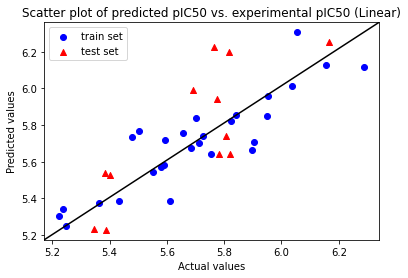

In [5]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred_train, c = 'blue', label='train set')
ax.scatter(y_test, y_pred_test, c = 'red', marker="^", label='test set')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color = 'black')
ax.legend()
plt.title('Scatter plot of predicted pIC50 vs. experimental pIC50 (Linear)')
plt.ylabel('Predicted values')
plt.xlabel('Actual values')
plt.show()

In [6]:
print(len(y_pred_train))
print(y_pred_train)

28
[5.67283085 6.01536323 5.84065066 5.24912168 5.58274847 5.38470595
 5.73823371 5.85169762 5.37241792 5.57040715 5.54186239 5.66579438
 5.75877075 5.38778101 6.11961555 6.3068871  5.76836054 5.82015989
 5.72016344 5.85257444 5.34301984 5.7348228  5.70104326 5.70614859
 5.64405821 5.30168046 5.96146564 6.1298612 ]


### QSAR Param

<AxesSubplot:>

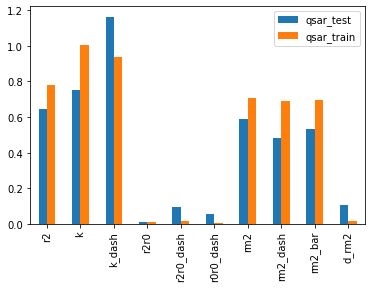

In [7]:
# test
qsar_result_test = qsar_param(y_test.values.ravel(),y_pred_test)
# train
qsar_result_train = qsar_param(y_train.values.ravel(),y_pred_train)

x = {'qsar_test':qsar_result_test, 'qsar_train':qsar_result_train}
df_x = pd.DataFrame(x)
df_x.plot(kind='bar')

In [8]:
qsar_result_test

{'r2': 0.6427432284615487,
 'k': 0.7533654736556897,
 'k_dash': 1.164057564080109,
 'r2r0': 0.011251492387483816,
 'r2r0_dash': 0.09640792528917451,
 'r0r0_dash': 0.05473372060750192,
 'rm2': 0.5880842727296564,
 'rm2_dash': 0.48274593605146177,
 'rm2_bar': 0.5354151043905591,
 'd_rm2': 0.10533833667819459}

In [9]:
qsar_result_train

{'r2': 0.7781456737385498,
 'k': 1.006358351662016,
 'k_dash': 0.9377326723226233,
 'r2r0': 0.011373039274642808,
 'r2r0_dash': 0.01589430189535974,
 'r0r0_dash': 0.003518200948146699,
 'rm2': 0.7049425472082478,
 'rm2_dash': 0.6916066304348051,
 'rm2_bar': 0.6982745888215265,
 'd_rm2': 0.013335916773442702}

In [10]:
from sklearn import svm

model_l = svm.SVR(kernel= 'linear', C= 10, degree= 1, epsilon= 0.01, gamma= 'auto')

y_random_result_train = y_random(model_l, x_train, y_pred_train)
y_random_result_train

0.011086949824447776

In [11]:
X = np.concatenate((x_train.to_numpy(), x_test.to_numpy()), axis = 0)
y = np.hstack((y_train.values.ravel(), y_test.values.ravel()))

q2_loo(model_l, X, y)

-0.048012177067958905

### Applicability Domain

28
h*= 0.86


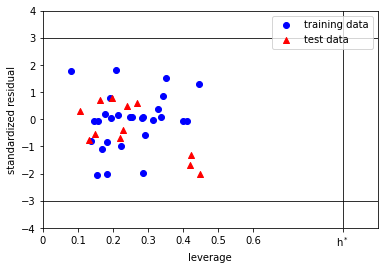

In [12]:
feat = ['AATS7i', 'ATS1p', 'C3SP2', 'maxsOm', 'TIC4', 'MLFER_L', 'SRW5']
x_test = x_test[feat]
x_train = x_train[feat]

# plicability_domain(X_train, X_test, y_train_act, y_train_pred, y_test_act, y_test_pred):
applicability_domain(x_train, x_test, y_train.values.ravel(), y_pred_train, y_test.values.ravel(), y_pred_test)

In [13]:
y_test.to_excel('y_test.xlsx', index = False)

In [14]:
y_train.to_excel('y_train.xlsx', index=False)

In [15]:
residual_test = y_test.values.ravel() - y_pred_test
# residual_train = y_train.values.ravel() - y_pred_train
res = pd.DataFrame()
res['y_pred_test'] = y_pred_test
res['residual'] = residual_test

residual_p=res[(res['residual'] > 0)]
residual_n=res[(res['residual'] < 0)]

res.insert(0, 'ID', range(28, 28 + len(res)))
res.to_excel('test_pred_residual_linear.xlsx', index=False)
res.head()

ID  y_pred_test  residual
0  28     5.993163 -0.300445
1  29     5.541036 -0.156566
2  30     5.527338 -0.124704
3  31     5.740710  0.067001
4  32     5.641121  0.181054

In [16]:
residual_train = y_train.values.ravel() - y_pred_train

res_t = pd.DataFrame()
res_t['y_pred_train'] = y_pred_train
res_t['residual'] = residual_train

res_t.insert(0, 'ID', range(0, len(res_t)))
res_t.to_excel('train_pred_residual_linear.xlsx', index=False)
res_t

ID  y_pred_train  residual
0    0      5.672831  0.010151
1    1      6.015363  0.020377
2    2      5.840651 -0.139722
3    3      5.249122 -0.001477
4    4      5.582748  0.008164
5    5      5.384706  0.225774
6    6      5.738234 -0.010308
7    7      5.851698  0.098697
8    8      5.372418 -0.010308
9    9      5.570407  0.010298
10  10      5.541862  0.010515
11  11      5.665794  0.232459
12  12      5.758771 -0.103359
13  13      5.387781  0.046962
14  14      6.119616  0.167735
15  15      6.306887 -0.252848
16  16      5.768361 -0.263905
17  17      5.820160  0.005199
18  18      5.720163 -0.127554
19  19      5.852574 -0.010031
20  20      5.343020 -0.105998
21  21      5.734823 -0.256092
22  22      5.701043  0.009591
23  23      5.706149  0.196941
24  24      5.644058  0.109936
25  25      5.301680 -0.076489
26  26      5.961466 -0.009907
27  27      6.129861  0.026906

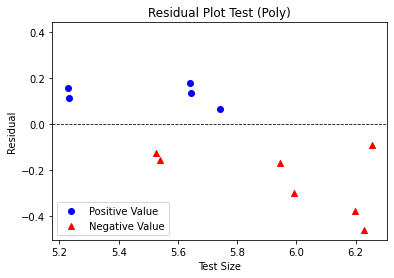

In [17]:
residual_t_p=res_t[(res_t['residual'] > 0)]
residual_t_n=res_t[(res_t['residual'] < 0)]

fig, ax = plt.subplots()
ax.scatter(residual_p['y_pred_test'], residual_p['residual'], c='blue', marker='o',label='Positive Value')
ax.scatter(residual_n['y_pred_test'], residual_n['residual'], c='red', marker='^',label='Negative Value')
plt.axhline(y=0, c='k', linewidth=0.8, ls='--')
plt.axhline(y=0.4, c='white')
ax.legend()
plt.title('Residual Plot Test (Poly)')
plt.xlabel('Test Size')
plt.ylabel('Residual')
plt.savefig('residual_png.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

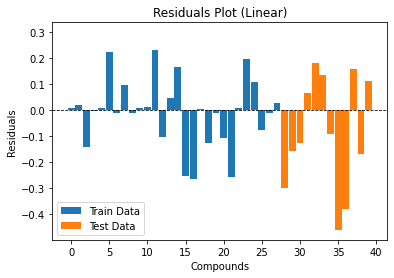

In [18]:
res_t.insert(0, 'type', 'Train Data')
res.insert(0, 'type', 'Test Data')

con = pd.concat([res_t, res])
# con.head()


fig, ax = plt.subplots()
ax.bar(res_t['ID'], res_t['residual'],  label='Train Data', width=0.9)
# ax.bar(res_t['ID'], res_t['residual'],  label='Train Data', width=0.9)
ax.bar(res['ID'], res['residual'],  label='Test Data', width=0.9)
plt.axhline(y=0, c='k', linewidth=0.8, ls='--')
plt.axhline(y=0.3, c='white')
ax.legend()
plt.title('Residuals Plot (Linear)')
plt.xlabel('Compounds')
plt.ylabel('Residuals')
plt.savefig('residual_bar.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

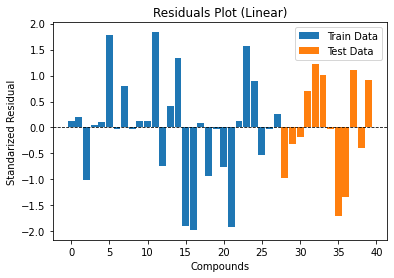

In [34]:
# std dev
from statistics import mean, stdev
dev = list(res['residual'])
avg_dev = mean(dev)
std_dev = stdev(dev)
standardized_dev = []
for i in range(len(dev)):
    standardized_dev.append((dev[i] - avg_dev)/std_dev)

res['standardized_residual'] = standardized_dev
# res

dev_t = list(res_t['residual'])
avg_dev_t = mean(dev_t)
std_dev_t = stdev(dev_t)
standardized_dev_t = []
for i in range(len(dev_t)):
    standardized_dev_t.append((dev_t[i] - avg_dev_t)/std_dev_t)

res_t['standardized_residual'] = standardized_dev_t
# res_t

fig, ax = plt.subplots()
ax.bar(res_t['ID'], res_t['standardized_residual'],  label='Train Data', width=0.9)
# ax.bar(res_t['ID'], res_t['residual'],  label='Train Data', width=0.9)
ax.bar(res['ID'], res['standardized_residual'],  label='Test Data', width=0.9)
plt.axhline(y=0, c='k', linewidth=0.8, ls='--')
# plt.axhline(y=0.3, c='white')
ax.legend()
plt.title('Residuals Plot (Linear)')
plt.xlabel('Compounds')
plt.ylabel('Standarized Residual')
plt.savefig('residual_bar.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()